# Machine learning
Tutta la parte dedicata al machine learning (regressione + classificazione) verrà scritta qui

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import pickle

#sklearn
#from sklearn.preprocessing import OneHotEncoder

# custom lib
import sys
sys.path.append('./../src')


import make_dataset as m_d
import ML_functions as supp_ML
# seed originario 86122330
np.random.seed(86122330)

# PRIMA TASK: prevedere l'attività di twitter a livello provinciale

In [4]:
# Importo i dati dal database finale (vedi Import Dati)
data = pd.read_csv(m_d.data_path_out / 'MachineLearningDB.csv')

# Smisto target e features
target_mattina = data['TargetDay']
target_sera = data['TargetNight']
data.drop(columns=['TargetDay', 'TargetNight'], inplace=True)


"""
#### PROBLEMA: questo encodda il weekday ma non lo svolge in colonne
#### (non è bello svolgerlo, e poco generale maybe)
# Encoder sul dato categorico weekday
enc = OneHotEncoder(sparse=False, handle_unknown='ignore')
data["Weekday"]=enc.fit_transform(data["Weekday"].values[:,None]).tolist()

NOTA: se inserisco un np.array(np.array) ad un dataframe MI TIENE SOLO PRIMO ELEMENTO (1.0<=>'Mo')
 Se converto a lista funziona

Nota: equivale a
data['Weekday'] = enc.fit(data["Weekday"].values[:,None])
data['Weekday'] = enc.transform(data["Weekday"].values[:,None]).tolist()

Nota: Per convertire i contenuti a np.array(), ma comunque non fa funzionare sklearn
temp=enc.fit_transform(data["Weekday"].values[:,None])
data["Weekday"]=[np.array(i) for i in temp]
"""

"""
# Facendo make_column_transformer funziona, ma meglio inserirlo nella pipeline
colTr = make_column_transformer( (StandardScaler(), ["Tweet1m", "Tweet2m", "Tweet1n", "Tweet2n",
                                                     "Tavg1m", "Tavg2m", "Tavg1n", "Tavg2n"]),
                                (OneHotEncoder(), ['Weekday']), remainder='passthrough')


#Restringere database di features, molte delle features ipotizzate contano poco, ed ho molti pochi dati
data=data[["Tweet1m", "Tweet2m", "Tweet1n", "Tweet2n", "Tavg1m", "Tavg2m", "Tavg1n", "Tavg2n", "Weekday"]]

#enc=OneHotEncoder(sparse=False, handle_unknown='ignore')
data=colTr.fit_transform(data)
data
"""
num_feat=["Tweet1m", "Tweet2m", "Tweet1n", "Tweet2n", "Tavg1m", "Tavg2m", "Tavg1n", "Tavg2n"]
cat_feat=["Weekday"]

data[num_feat+cat_feat].head(6)



,Tweet1m,Tweet2m,Tweet1n,Tweet2n,Tavg1m,Tavg2m,Tavg1n,Tavg2n,Weekday
0,149,165,44,92,11.245556,12.132153,9.895139,10.252631,Su
1,115,149,74,44,12.137079,11.245556,7.764167,9.895139,Mo
2,90,115,54,74,7.444653,12.137079,6.732540,7.764167,Tu
3,106,90,56,54,10.234794,7.444653,6.847639,6.732540,We
4,102,106,55,56,10.780688,10.234794,6.581250,6.847639,Th
5,88,102,92,55,10.987268,10.780688,6.968611,6.581250,Fr


In [5]:
#MATTINA:
PL_Matt_Logistic=supp_ML.logistic_regressor_fittato(data, target_mattina, num_feat, cat_feat)
PL_Matt_RF=supp_ML.Random_Forest_Regressor_CV(data, target_mattina, num_feat, cat_feat)

Logistic regression r2_score = 0.3928198052884144
Random forest r2_score =  0.4729625222709424
Random forest (gridSearchCV) r2_score =  0.5965676476187041


In [7]:
# salvo i dati
filename1 = 'Finalized_Logistic_morning.sav'
filename2 = 'Finalized_RF_morning.sav'
pickle.dump(PL_Matt_Logistic, open(filename1, 'wb'))
pickle.dump(PL_Matt_RF, open(filename2, 'wb'))

Nota: se tolgo handle_unknown="ignore" dal one hot encoder raisa un messaggio di errore a volte (dipende dal random seed del problema), il seed 86122330 attiva il problema (eseguendo il notebook in ordine). \
Vista la soluzione al problema si penserebbe che sia un problema del one hot encoder, ma non vedo perchè dovrebbe **a volte** fallire. L'unica cosa che ho pensato era "forse nell'insieme di train non ci sono tutti i giorni della settimana", ma printare
```python
PL_Matt_RF["transformer"].transformers_[1][1].categories_
```
oppure (se uso il gridsearch)
```python
PL_Matt_RF.best_estimator_["transformer"].transformers_[1][1].categories_
```
dimostra che questo non è il problema. Il warning è raisato nella parte di CV durante il fit \
Nota: l'errore contiene 432 NaNs, che sono i 432 candidati della gridsearch (in teoria); non so se implichi qualcosa questo \
Nota: se faccio l'ignore aumenta drasticamente l'r2, probabilmente perchè aumentano di molto i punti di training

## Osservazioni:
**Regressione:** altissima varianza valore r2, ho molti pochi dati per fare questa stima (also, ci sono i dati del fine anno e delle feste che sballano tutto) \
**Random Forest:** piuttosto stabile nonostante lo scarso numero di dati (as predicted), sicuramente better-than-random ma visto il basso numero di dati non riscontriamo successi strepitosi



In [9]:
#SERA
PL_Sera_Logistic=supp_ML.logistic_regressor_fittato(data, target_sera, num_feat, cat_feat)
PL_Sera_RF=supp_ML.Random_Forest_Regressor_CV(data, target_sera, num_feat, cat_feat)

#More of the same, niente di strano

Logistic regression r2_score = -0.011681645677269259
Random forest r2_score =  0.24978353295653544
Random forest (gridSearchCV) r2_score =  0.4716935789521335


In [10]:
# Salvo i modelli
filename1 = 'Finalized_Logistic_evening.sav'
filename2 = 'Finalized_RF_evening.sav'
pickle.dump(m_d.models_path / PL_Sera_Logistic, open(filename1, 'wb'))
pickle.dump(m_d.models_path / PL_Sera_RF, open(filename2, 'wb'))

# SECONDA TASK: identificare la circoscrizione con più tweets associati
Le classi che effettivamente compaiono nei nostri dati sono solo 2, tanto vale andare di ROC e precision recall per massimizzare la comprensione dei modelli (ovviamente aumentando il numero di dati potrebbe non essere vero)\
Le classi sono fortemente sbilanciate, tant'è vero che il nostro predittore predice (quasi) sempre piedicastello con il risultato che l'accuracy è piuttosto buona in quanto non riesce a discriminare classi sbilanciate, ma guardando la CM è ovvio che la predizione è funzionalmente random. Si nota infatti che la ROC è generalmente con un modello puramente random, in quanto è una curva largamente diagonale

In [2]:
# creo il vettore delle y trovando qual è la circoscrizione più attiva
targetCirc = supp_ML.circoscrizione_attiva(m_d.data_path_out / "twitter_final.csv")
targetCirc = pd.Series(targetCirc)
targetCirc.drop([targetCirc.index[0], targetCirc.index[1]], inplace=True)
Counter(targetCirc)


Counter({'CENTRO STORICO PIEDICASTELLO': 47, 'OLTREFERSINA': 12})

Lo score della nostra Random Forest risulta essere: 0.7083333333333334 per il riconoscimento delle circoscrizioni più attive


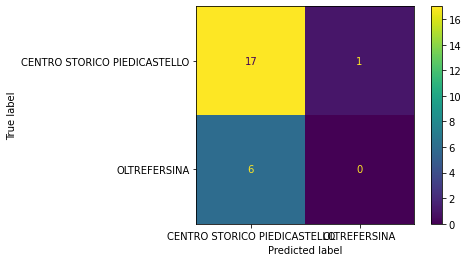

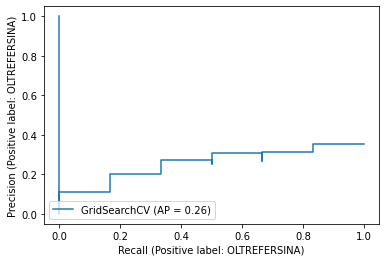

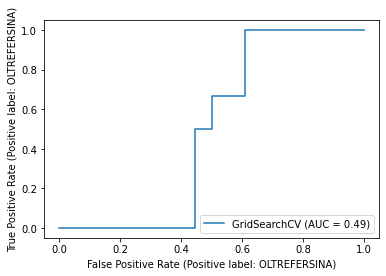

In [5]:
# Random Forest Classifier
PL_classPred=supp_ML.Random_Forest_Classifier_Circoscrizione(data, targetCirc, num_feat, cat_feat)

In [ ]:
#And save
filename1 = 'Circoscrizioni.sav'
pickle.dump(m_d.models_path / PL_classPred, open(filename1, 'wb'))